In [1]:
import numpy as np

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
sys.path.append("..")

from src.datasets import Dataset
from src.metrics import LT_dendrogram_purity, class_purity, node_statistics
from src.LT_models import LTRegressor
from src.optimization import evaluate

In [2]:
LOAD_DIR = "../results/clustering-selfsup/GLASS/out-feats=[0, 1]/depth=6/reg=17.893973029582362/seed=1225/"

additional_load = {'checkpoint': None}
model = LTRegressor.load_model(LOAD_DIR, additional_load)
checkpoint = additional_load['checkpoint']

In [3]:
DATA_NAME = checkpoint['dataset']
SEED = checkpoint['seed']

MAX_DEPTH = 3
leaves = range(2**MAX_DEPTH - 1, 2**(MAX_DEPTH+1) - 1)

out_features = checkpoint['out_features']
in_features = checkpoint['in_features']

data = Dataset(DATA_NAME, in_features=in_features, out_features=out_features, seed=459107, normalize=True)

X = np.vstack((data.X_train_in, data.X_valid_in, data.X_test_in))
Y = np.vstack((data.X_train_out, data.X_valid_out, data.X_test_out))
true_y = np.hstack((data.y_train, data.y_valid, data.y_test))

Normalize dataset


In [4]:
NB_CLASSES = np.max(true_y) + 1

_, class_hist, _ = class_purity(X, true_y, model, model.latent_tree.bst, NB_CLASSES)
class_hist = class_hist[:, :2**(MAX_DEPTH+1) - 1]

for c in range(NB_CLASSES):

    class_hist[c] = model.latent_tree.bst.normalize(class_hist[c], MAX_DEPTH)
    
stats = node_statistics(X, Y, model, MAX_DEPTH)
*_, labels, _ = node_statistics(X, true_y, model, MAX_DEPTH)

if len(stats) == 5:
    medians, means, stds, y_distrs, zs = stats
else:
    stds, y_distrs, zs = stats

../src/metrics.py:33: RuntimeWarning: invalid value encountered in true_divide
  purity = np.nan_to_num(class_hist / np.sum(class_hist, axis=0)) # node's fraction of points of a class
../src/trees.py:71: RuntimeWarning: invalid value encountered in true_divide
  z[i:i + 2 ** d] /= sum(z[i:i + 2 ** d])
/home/vale/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/vale/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/vale/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/vale/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vale/miniconda3/lib/python3.7/si

In [5]:
# build graph for visualization
G = nx.from_numpy_array(model.latent_tree.bst.to_adj_matrix(MAX_DEPTH))
pos = graphviz_layout(G, prog='dot')

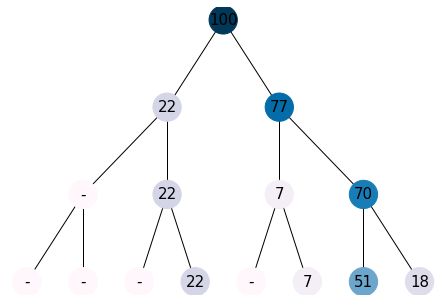

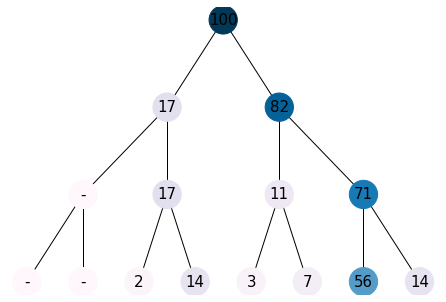

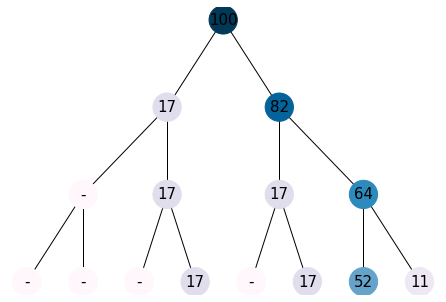

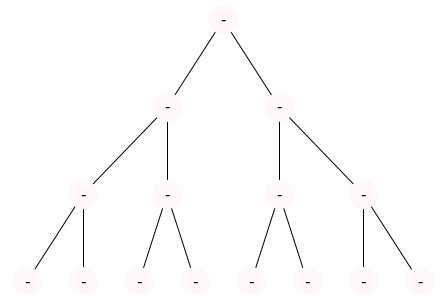

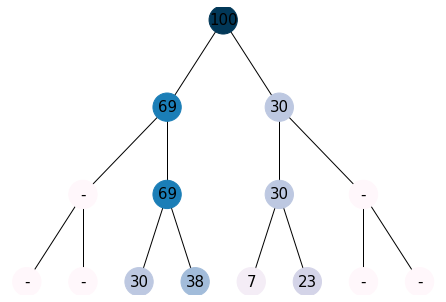

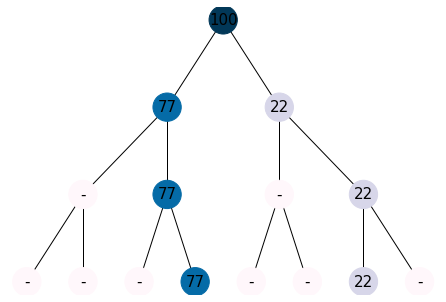

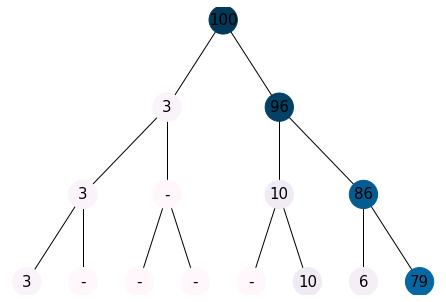

In [15]:
# plot a tree per class
for c in range(NB_CLASSES):
    plt.figure(c)

    nx.draw(G, pos, node_size=800,font_size=15, labels={i: int(d*100) if d > 0 else "-" for i, d in enumerate(class_hist[c])}, arrows=True, node_color=class_hist[c], cmap=plt.cm.PuBu)

    plt.savefig(f'{LOAD_DIR}class{c}.pdf', bbox_inches='tight')
    

### PRUNING

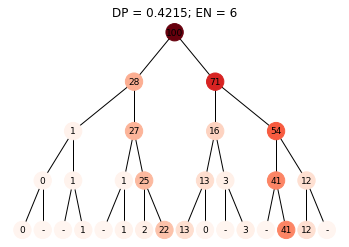

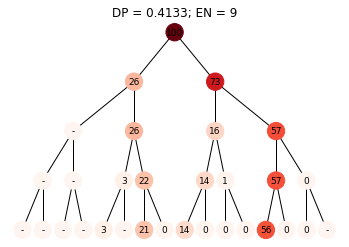

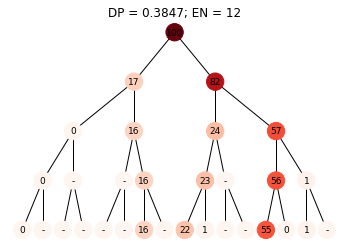

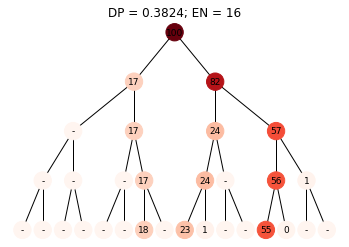

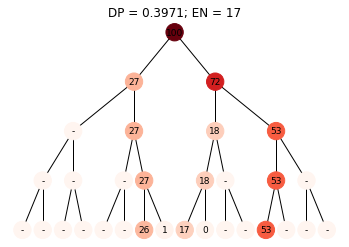

In [40]:
ens = []
for i, REG in enumerate([0, 0.0001, 0.001, 0.01, 0.1]):
    
    LOAD_DIR = f"../results/clustering-selfsup/GLASS/pruning/reg={REG}"

    additional_load = {'checkpoint': None}
    model = LTRegressor.load_model(LOAD_DIR, additional_load)
    checkpoint = additional_load['checkpoint']

    depth = checkpoint['bst_depth']
    
    dp, class_hist = LT_dendrogram_purity(X, true_y, model, model.latent_tree.bst, NB_CLASSES)

    hist_routing = np.sum(class_hist, 0)
    hist_routing = model.latent_tree.bst.normalize(hist_routing)
    
    ens.append(sum(hist_routing == 0))
    
    G = nx.from_numpy_array(model.latent_tree.bst.to_adj_matrix())
    pos = graphviz_layout(G, prog='dot')
    
    plt.figure(i)
    
    plt.title(f'DP = {np.round(dp, decimals=4)}; EN = {sum(hist_routing == 0)}')

    nx.draw(G, pos, font_size=9, labels={i: int(d * 100) if d > 0 else "-" for i, d in enumerate(hist_routing)}, arrows=True, node_color=hist_routing, cmap=plt.cm.Reds)

    plt.savefig(f'{LOAD_DIR}/../reg={REG}.svg', bbox_inches='tight')

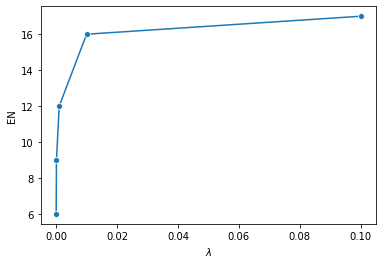

In [36]:
sns.lineplot([0, 0.0001, 0.001, 0.01, 0.1], ens, marker='o')
plt.xlabel("$\lambda$")
plt.ylabel("EN")

plt.savefig(f'{LOAD_DIR}/all-reg.pdf', bbox_inches='tight')